# Analyzing newsletter urls

---

In [20]:
%matplotlib inline

# Imports

import re
import os
import json
import pprint
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Variables

pp = pprint.PrettyPrinter(indent=4)

# Read data

data = []
with open('./emails.json') as input_file:
    for line in input_file:
        data.append(json.loads(line))

In [21]:
df = pd.DataFrame(data)

In [22]:
print "Number of emails downloaded:",df.shape[0]

Number of emails downloaded: 438


In [23]:
df.head(3)

,date,from,subject,to,urls
0,"Fri, 18 Mar 2016 10:13:47 +0100",Laia Izquierdo <lizquierdo@bluecap.com>,Buecap banking breakfast,bluecapglobal@bluecap.com,[http://cincodias.com/cincodias/2016/03/17/mer...
1,"Mon, 21 Mar 2016 10:05:11 +0100",Laia Izquierdo <lizquierdo@bluecap.com>,Bluecap banking breakfast,bluecapglobal@bluecap.com,[http://www.expansion.com/empresas/banca/2016/...
2,"Thu, 24 Mar 2016 10:08:11 +0100",Laia Izquierdo <lizquierdo@bluecap.com>,Bluecap banking breakfast,bluecapglobal@bluecap.com,[http://www.elconfidencial.com/mercados/2016-0...


In [24]:
df.groupby('subject').size().sort_values(0, ascending=False).reset_index().rename(columns={0:"count"}).head(5)

,subject,count
0,Bluecap Banking Breakfast,344
1,Bluecap banking breakfast,30
2,Bluecap Banking Brunch,18
3,Re: Doc Caixa,3
4,=?UTF-8?Q?Re=3A_Si_us_plau=2C_recorda_enviar=2...,3


In [25]:
# Extract all article urls

urls = []

for idx, row in df.iterrows():
    if row['urls']:
        try:
            for url in row['urls']:
                urls.append(url)
        except:
            print idx, row['urls']
            pass

In [26]:
# Delete possible dups
urls = list(set(urls))

In [27]:
df_urls = pd.DataFrame(urls).rename(columns={0:"url"})
df_urls.head(5)

,url
0,http://www.expansion.com/empresas/banca/2018/0...
1,http://www.expansion.com/ahorro/2018/03/09/5aa...
2,http://www.expansion.com/empresas/banca/2017/0...
3,http://www.expansion.com/empresas/banca/2017/1...
4,http://www.expansion.com/empresas/banca/2016/0...


In [28]:
df_urls['source'] = df_urls['url'].apply(lambda x: re.findall('(?:\/\/www\.|\/\/)(\w+)\.\w',x))
df_urls.head(5)

,url,source
0,http://www.expansion.com/empresas/banca/2018/0...,[expansion]
1,http://www.expansion.com/ahorro/2018/03/09/5aa...,[expansion]
2,http://www.expansion.com/empresas/banca/2017/0...,[expansion]
3,http://www.expansion.com/empresas/banca/2017/1...,[expansion]
4,http://www.expansion.com/empresas/banca/2016/0...,[expansion]


In [29]:
for idx, row in df_urls.iterrows():
    source = row['source']
    try:
        df_urls.loc[idx, 'source'] = source[0]
    except:
        df_urls.loc[idx, 'source'] = ""

In [30]:
source = df_urls.groupby('source').size().sort_values(0, ascending=False).reset_index().rename(columns={0:"count"})
source.head(10)

,source,count
0,expansion,2592
1,cincodias,1285
2,elconfidencial,858
3,bernsteinresearch,78
4,blogs,36
5,retina,14
6,federalreserve,9
7,google,9
8,economia,6
9,bloomberg,4


In [31]:
print "Number of different urls extracted:", df_urls.shape[0]

Number of different urls extracted: 4961


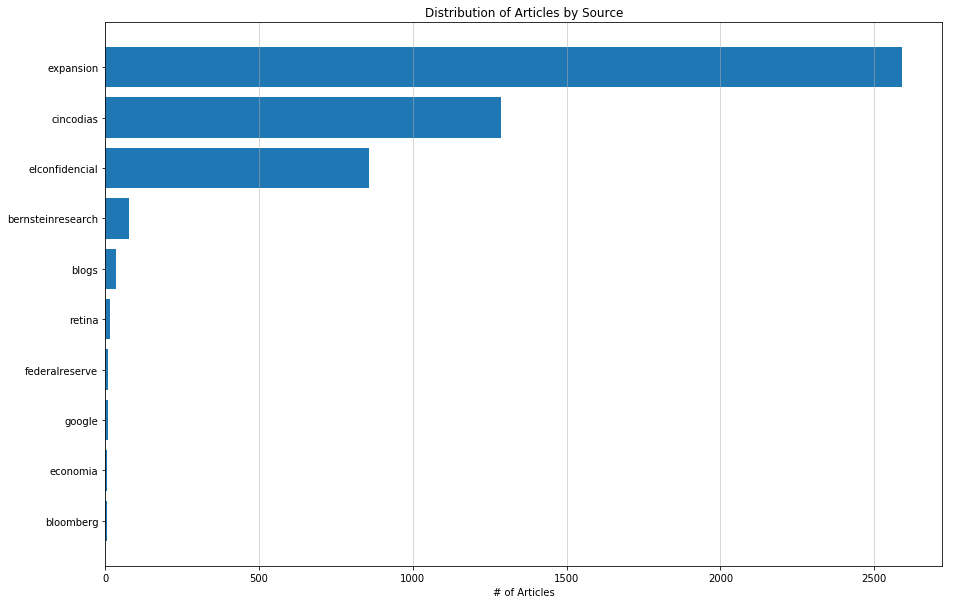

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))

y_pos = np.arange(len(list(source['source'])[:10]))

ax.barh(y_pos, list(source['count'])[:10], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(list(source['source'])[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# of Articles')
ax.set_title('Distribution of Articles by Source')
ax.xaxis.grid(which='major', linewidth=0.5)

plt.show()

In [33]:
# let's check that urls are properly extracted ...

df_urls['url_length'] = df_urls['url'].apply(lambda x: len(x))

In [34]:
df_urls.sort_values('url_length').head(20)

,url,source,url_length
2364,https://cincodia,,16
4835,http://diario.es,diario,16
4204,http://macauhub.com,macauhub,19
2749,http://somosmuno.com,somosmuno,20
2575,http://salesforce.com,salesforce,21
902,http://www.bluecap.com,bluecap,22
800,http://www.bluecap.com/,bluecap,23
4668,http://www.expansion.com/,expansion,25
403,http://www.aknowledge.us/,aknowledge,25
731,http://www.extelsurveys.com,extelsurveys,27


In [35]:
# There are a few <a> tags that do not contain urls (telephones, mailto, ...)
# We will only consider those urls with 'http' string

df_urls['valid_url'] = df_urls['url'].apply(lambda x: 'http' in x)

In [36]:
df_urls.sort_values('url_length').head(20)

,url,source,url_length,valid_url
2364,https://cincodia,,16,True
4835,http://diario.es,diario,16,True
4204,http://macauhub.com,macauhub,19,True
2749,http://somosmuno.com,somosmuno,20,True
2575,http://salesforce.com,salesforce,21,True
902,http://www.bluecap.com,bluecap,22,True
800,http://www.bluecap.com/,bluecap,23,True
4668,http://www.expansion.com/,expansion,25,True
403,http://www.aknowledge.us/,aknowledge,25,True
731,http://www.extelsurveys.com,extelsurveys,27,True


In [37]:
# There are a few urls (#2103, #2163, ...) that we would like to get rid off eventhough they contain 'http'

In [38]:
print "There are roughly", df_urls[df_urls['valid_url']==True].shape[0], "valid urls"

There are roughly 4961 valid urls


# Conclusions

* We will modify the email download script to not include invalid urls